In [1]:
import numpy as np
import osmnx as ox
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

import random
import pickle

import mlrfit as mf
import lrrouting as ldr

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def weight_a_b(adjacency_list, a, b):
    for c in adjacency_list[a]:
        if c[0] == b:
            return c[1]
        

def route_with_dfs(s, t, dar):
    if s == t:
        return [s], 0
    used = [False] * len(dar.nodes)
    stack = [(0, [s])]
    while stack != []: 
        wpath, path_a = stack.pop()
        a = path_a[-1]
        if not used[a]:
            if a == t:
                break
            used[a] = True
            idx_sorted, d_at = dar._sort_dist_a_Na_t(a=a, t=t)
            # stack processed nodes in reversed order, look at nodes in the order of increasing distance from it to t
            for b_idx in idx_sorted[::-1]: 
                b_next, w_ab = dar.adjacency_list[a][b_idx]
                if not used[b_next]:
                    stack += [(wpath + w_ab, path_a + [b_next])]
    assert path_a[-1] == t
    return path_a, wpath


def route_with_backtracking(s, t, dar):
    import copy
    if s == t:
        return [s], 0
    stack = [(0, [s])]
    min_dist = np.inf
    min_path = []
    while stack != []: 
        wpath, path_a = stack.pop()
        a = path_a[-1]
        if a == t:
            if wpath < min_dist: 
                min_path = copy.deepcopy(path_a)
                min_dist = wpath
        idx_sorted, d_at = dar._sort_dist_a_Na_t(a=a, t=t)
        # stack processed nodes in reversed order, look at nodes in the order of increasing distance from it to t
        for b_idx in idx_sorted[::-1]: 
            b_next, w_ab = dar.adjacency_list[a][b_idx]
            if b_next not in path_a and wpath + w_ab <= min_dist:
                stack += [(wpath + w_ab, path_a + [b_next])]
    assert min_path[-1] == t
    return min_path, min_dist

In [3]:
G = nx.Graph()
n = 5
num_nodes = n + 2
G.add_nodes_from(range(n + 2))
G.add_edges_from(nx.cycle_graph(n).edges)
G.add_edges_from([(i-1, i) for i in range(n, n+2)])

for (u, v) in G.edges():
    G[u][v]['weight'] = np.random.randint(1, 10)

In [4]:
Adj, Dist = ldr.nx_graph_to_matrices(G)
adjacency_list = ldr.adjacency_list(Adj)

assert len(adjacency_list[n-1]) == 3

in  degrees: {0: 0, 1: 1, 2: 5, 3: 1}
out degrees: {0: 0, 1: 1, 2: 5, 3: 1}


In [5]:
s = n - 1
t = n + 1
N_loop = [0, n - 2]
N_path = [n]
# corrupt dist matrix to have s-t shortest path going through the loop
corrupt_Dist = np.copy(Dist)
for v in N_path:
    corrupt_Dist[v, t] = 15 * n
    corrupt_Dist[t, v] = 15 * n

U, Vt, sigmas = mf.frob_low_rank(corrupt_Dist, dim=num_nodes)
sqrt_sigmas = np.sqrt(np.maximum(sigmas, 0))
B = U * sqrt_sigmas
C = Vt.T * sqrt_sigmas

assert np.allclose(B @ C.T, corrupt_Dist)

lollipop_dar = ldr.construct_lr_graph(B, C, adjacency_list)

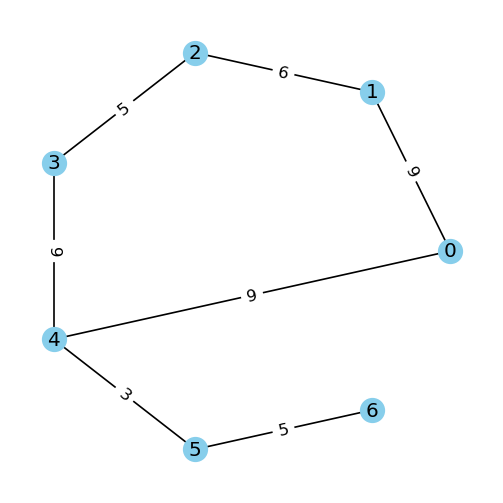

In [6]:
ldr.plot_nx_G(G)

In [7]:
B, C = ldr.low_rank_approx(Dist, dim=None, symm=False, v0=None)
assert np.allclose(Dist, B @ C.T)

dar = ldr.construct_lr_graph(B, C, adjacency_list)
route, wroute = dar.route(s=s, t=t)

route2, wroute2 = route_with_dfs(s, t, lollipop_dar)

assert route == [s, n, t] == route2
assert Dist[s, t] == wroute == wroute2
print("PASSED")

PASSED


In [8]:
G = nx.Graph()
n = 5
num_nodes = 2 * n + 2
G.add_nodes_from(range(n + 2))
G.add_edges_from(nx.cycle_graph(n).edges)
G.add_edges_from([(i, i+1) for i in range(5, 2*n-1)] + [(2*n-1, n)])
G.add_edges_from([(n-1, n), (n, 2*n), (2*n, 2*n + 1)])

for (u, v) in G.edges():
    G[u][v]['weight'] = np.random.randint(1, 10)

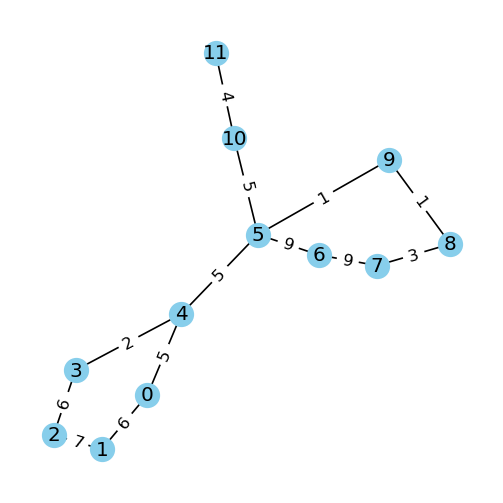

In [9]:
ldr.plot_nx_G(G, f_layout=nx.spring_layout)

In [10]:
Adj, Dist = ldr.nx_graph_to_matrices(G)
adjacency_list = ldr.adjacency_list(Adj)

assert len(adjacency_list[n - 1]) == 3 == len(adjacency_list[n])-1

in  degrees: {0: 0, 1: 1, 2: 9, 3: 1, 4: 1}
out degrees: {0: 0, 1: 1, 2: 9, 3: 1, 4: 1}


In [11]:
s = n - 1
t = 2 * n + 1
N_loop1 = [0, n - 2]
N_loop2 = [n + 1, 2 * n - 1]
N_path = [2 * n]
# corrupt dist matrix to have s-t shortest path going through the loop1 and loop2 and then line
corrupt_Dist = np.copy(Dist)
corrupt_Dist[s+1, t] = 15 * n
corrupt_Dist[t, s+1] = 15 * n

corrupt_Dist[s, t] = 25 * n
corrupt_Dist[t, s] = 25 * n

for v in N_loop2:
    corrupt_Dist[v, t] = 15 * n
    corrupt_Dist[t, v] = 15 * n

for v in N_path:
    corrupt_Dist[v, t] = 20 * n
    corrupt_Dist[t, v] = 20 * n

U, Vt, sigmas = mf.frob_low_rank(corrupt_Dist, dim=num_nodes)
sqrt_sigmas = np.sqrt(np.maximum(sigmas, 0))
B = U * sqrt_sigmas
C = Vt.T * sqrt_sigmas

assert np.allclose(B @ C.T, corrupt_Dist)

lollipop2_dar = ldr.construct_lr_graph(B, C, adjacency_list)

In [12]:
adjacency_list[5], corrupt_Dist[t,:]

([(4, 5.0), (6, 9.0), (9, 1.0), (10, 5.0)],
 array([ 19.,  25.,  22.,  16., 125.,  75.,  75.,  14.,  11.,  75., 100.,
          0.]))

In [13]:
# route, wroute = route_with_dfs(s, t, lollipop2_dar)
route, wroute = lollipop2_dar.route(s=s, t=t)
print(wroute, route)
assert all([v in route for v in [s, s+1, N_path[0], t]]) 
assert Dist[s, t] == wroute
print("PASSED")

14.0 [4, 5, 10, 11]
PASSED


In [14]:
G = nx.Graph()
num_nodes = n = 10
G.add_edges_from(nx.path_graph(n).edges)

for (u, v) in G.edges():
    G[u][v]['weight'] = 10

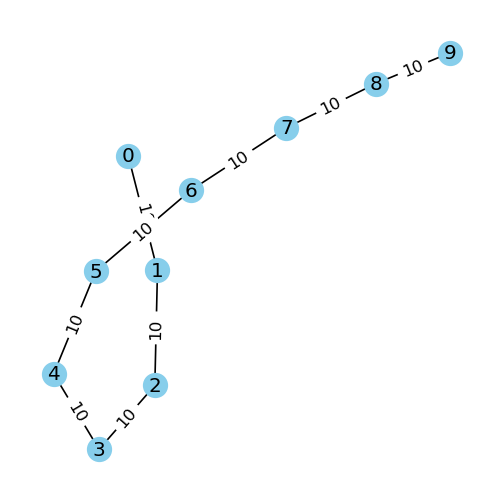

In [15]:
ldr.plot_nx_G(G, f_layout=nx.spring_layout)

In [16]:
Adj, Dist = ldr.nx_graph_to_matrices(G)
adjacency_list = ldr.adjacency_list(Adj)

assert (Adj == Adj.T).all()

in  degrees: {0: 0, 1: 2, 2: 8}
out degrees: {0: 0, 1: 2, 2: 8}


In [17]:
s = n // 2
t = n - 1
N_loop1 = [0, n - 2]
N_loop2 = [n + 1, 2 * n - 1]
N_path = [2 * n]
# corrupt dist matrix to have s-t shortest path going through the loop1 and loop2 and then line
corrupt_Dist = np.copy(Dist)
for v in [s, s+1]:
    corrupt_Dist[v, t] = n * 10
    corrupt_Dist[t, v] = n * 10
dist = 10 * (n - (s + 1))
for v in range(s):
    corrupt_Dist[v, t] = (v + 1) * 10
    corrupt_Dist[t, v] = (v + 1) * 10

assert  (corrupt_Dist >= 0).all()

B, C = ldr.low_rank_approx(corrupt_Dist, dim=None, symm=False, v0=None)
assert np.allclose(B @ C.T, corrupt_Dist)

path_dar = ldr.construct_lr_graph(B, C, adjacency_list)

In [18]:
adjacency_list[5], corrupt_Dist[t,:]

([(4, 10.0), (6, 10.0)],
 array([ 10.,  20.,  30.,  40.,  50., 100., 100.,  20.,  10.,   0.]))

In [19]:
# route, wroute = route_with_dfs(s, t, path_dar)
route, wroute = path_dar.route(s=s, t=t)
print(wroute, route)
assert all([v in route for v in range(s, t+1)])
assert Dist[s, t] == wroute
print("PASSED")

40.0 [5, 6, 7, 8, 9]
PASSED


In [20]:
G = nx.Graph()
num_nodes = n = 7
G.add_nodes_from(range(n))
G.add_edges_from([(0, 2), (0, 1), (1, 4), (4, 3), (4, 5), (5, 3), (5, 6), (6, 3), (6, 2), (2, 3)])

for (u, v) in G.edges():
    G[u][v]['weight'] = 10

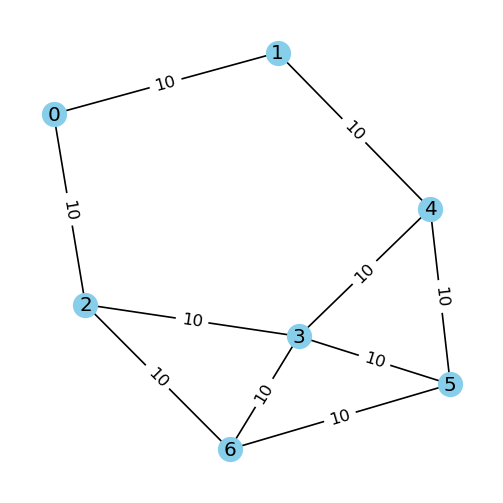

In [21]:
ldr.plot_nx_G(G, f_layout=nx.spring_layout)

In [22]:
Adj, Dist = ldr.nx_graph_to_matrices(G)
adjacency_list = ldr.adjacency_list(Adj)

in  degrees: {0: 0, 1: 0, 2: 2, 3: 4, 4: 1}
out degrees: {0: 0, 1: 0, 2: 2, 3: 4, 4: 1}


In [23]:
B = C = np.abs(np.random.randn(n, n))
path_dar = ldr.construct_lr_graph(B, C, adjacency_list)

In [24]:
s = 5
t = 0
# route, wroute = route_with_dfs(s, t, path_dar)
route, wroute = path_dar.route(s=s, t=t)
print(wroute, route)
print("PASSED")

30.0 [5, 3, 2, 0]
PASSED


In [25]:
s = 5
t = 0
route, wroute = route_with_backtracking(s, t, path_dar)
print(wroute, route)
assert Dist[s, t] == wroute
print("PASSED")

30.0 [5, 3, 2, 0]
PASSED
